In [1]:
import cv2
import csv
import math
import pickle

import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from numpy import newaxis
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Lambda

Using TensorFlow backend.


In [2]:
def crop_image(image, top_crop=0.5, bottom_crop=0.3):
    shape = image.shape
    from_index = math.floor(shape[0] * top_crop)
    to_index = math.ceil(shape[0] * (1 - bottom_crop))
    return image[from_index:to_index, 0:shape[1]]

In [3]:
def resize_image(image, size=(32, 32)):
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)

In [4]:
%matplotlib inline

debug = False

def process_image(file_name):
    img = mpimg.imread(file_name)
    if debug:
        plt.imshow(img)
        plt.show()
        print(img.shape)

    shape = img.shape
    img_crop = crop_image(img)
    if debug:
        plt.imshow(img_crop)
        plt.show()
        print(img_crop.shape)

    img_resize = resize_image(img_crop)
    if debug:
        plt.imshow(img_resize)
        plt.show()
        print(img_resize.shape)

    img_normalize = (img_resize / 255.0) - 0.5
    return img_normalize

p = process_image('data/IMG/center_2016_12_01_13_34_27_286.jpg')
p = process_image('data/IMG/center_2016_12_01_13_32_50_121.jpg')

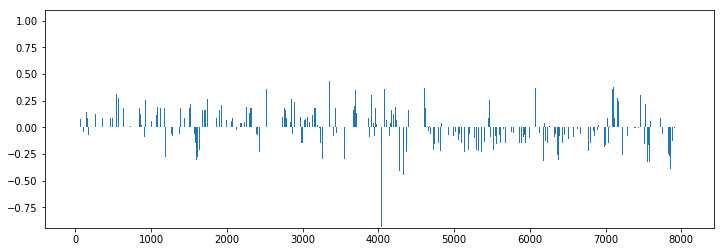

In [5]:
def plot_data():
    with open('data/driving_log.csv') as driving_log_file:
        driving_log_reader = csv.DictReader(driving_log_file)
        steering_angles = [float(row['steering']) for row in driving_log_reader]
        plt.figure(figsize=(12, 4))
        plt.bar(range(len(steering_angles)), steering_angles)
        plt.show()

plot_data()

In [6]:
def read_data(batch_size):
    """
    Generator function to load driving logs and input images.
    """
    while 1:
        with open('data/driving_log.csv') as driving_log_file:
            driving_log_reader = csv.DictReader(driving_log_file)
            count = 0
            inputs = []
            targets = []
            try:
                for row in driving_log_reader:
                    image = process_image('data/'+ row['center'])
                    flip_image = np.fliplr(image)
                    steering_angle = float(row['steering'])
                    if count == 0:
                        inputs = np.empty([0, 32, 32, 3], dtype=float)
                        targets = np.empty([0, ], dtype=float)
                    if count < int(batch_size/2):
                        inputs = np.append(inputs, np.array([image, flip_image]), axis=0)
                        targets = np.append(targets, np.array([steering_angle, -steering_angle]), axis=0)
                        count += 1
                    else:
                        yield inputs, targets
                        count = 0
            except StopIteration:
                pass

In [8]:
batch_size = 100

# define model
model = Sequential()

# color space transformation
model.add(Convolution2D(3, 1, 1, border_mode='valid', activation='elu', input_shape=(32, 32, 3)))

# sharpen
model.add(Convolution2D(6, 3, 3, border_mode='valid', activation='elu'))

# filter and sample
model.add(Convolution2D(12, 5, 5, border_mode='valid', subsample=(2,2), activation='elu'))

# larger filter and sample
model.add(Convolution2D(16, 5, 5, border_mode='valid', subsample=(2,2), activation='elu'))

model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# train model
model.fit_generator(read_data(batch_size), samples_per_epoch=16000, nb_epoch=5)
model.save('model.h5')


Epoch 1/5
16000/16000 [==============================] - 37s - loss: 0.0205 - acc: 0.5406      